# Experiments with water normalization

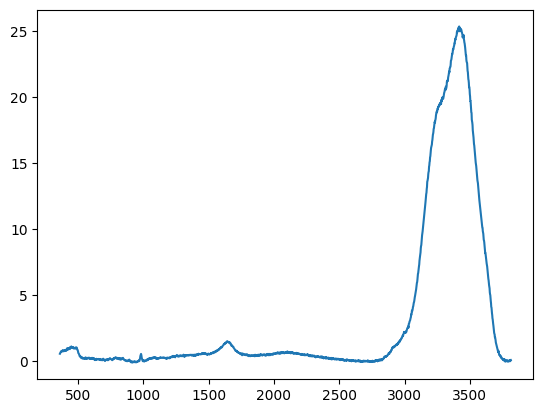

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load pure water
x_axis_water = []
values_water = []
# TODO: insert normal water
with open('sea_water_mean.txt') as pure_spectrum:
    for line in pure_spectrum:
        x, val = line.split()
        x_axis_water.append(float(x))
        values_water.append(float(val))

plt.plot(x_axis_water, values_water)
plt.show()

In [7]:
import scipy

# load .mat data with expected structure
in_file = '../data/Gefionella_processed_before_norm.mat'
mdict = {}
matlab_data = scipy.io.loadmat(in_file, mdict=mdict)

name = list(mdict)[-1]
matlab_data = matlab_data[name][0, 0]

data = matlab_data[7]

map_shape = tuple(matlab_data[5][0])

x_axis = matlab_data[9][1][0][0]
# data = np.reshape(data, (map_shape[1], map_shape[0], -1))
print(data.shape)

(1200, 1535)


Index of first non-NaN value: 7
Index of last non-NaN value: 1534
(1200, 1528)
[0.5941801  0.66723098 0.66664362 ... 0.04444655 0.01488317 0.01380998]
(1528,)


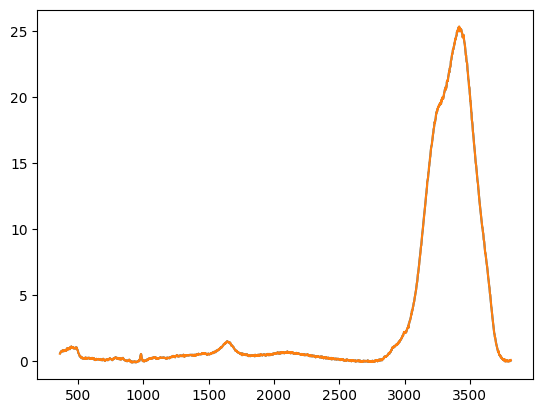

In [8]:
# interpolate the pure water and get values in the datapoints we had in the original data (berofe detrending)

import scipy.interpolate as si

spectrum_spline = si.CubicSpline(x_axis_water, values_water, axis=2, extrapolate=False)
aligned_values_water = spectrum_spline(x_axis)

# align the x axes

# Find the index of the first non-NaN value
first_non_nan_index = np.where(~np.isnan(aligned_values_water))[0][0]

# Find the index of the last non-NaN value
last_non_nan_index = np.where(~np.isnan(aligned_values_water))[0][-1]

print("Index of first non-NaN value:", first_non_nan_index)
print("Index of last non-NaN value:", last_non_nan_index)

x_axis = x_axis[first_non_nan_index:last_non_nan_index+1]
aligned_values_water = aligned_values_water[first_non_nan_index:last_non_nan_index+1]
data = data[:, first_non_nan_index:last_non_nan_index+1]
print(data.shape)

print(aligned_values_water)
print(aligned_values_water.shape)

plt.plot(x_axis, aligned_values_water)
plt.plot(x_axis_water, values_water)
plt.show()

In [9]:
# Calculate the differences so that we get rid of the different height of the spectras

def calculate_differences(spectra):
    differences = np.array([np.diff(spectrum) for spectrum in spectra])
    return differences

differences_spectra = calculate_differences(data)
print(differences_spectra.shape)

differences_water = calculate_differences(aligned_values_water.reshape((1, -1)))
print(differences_water.shape)


(1200, 1527)
(1, 1527)


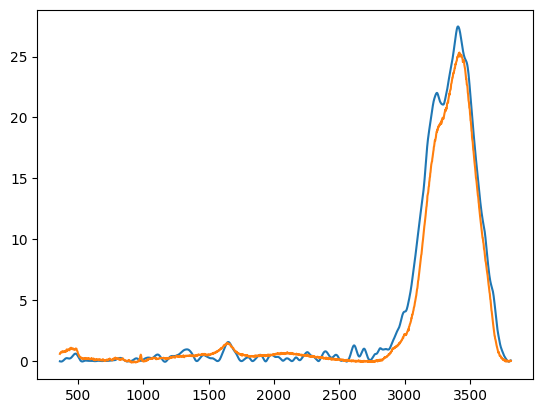

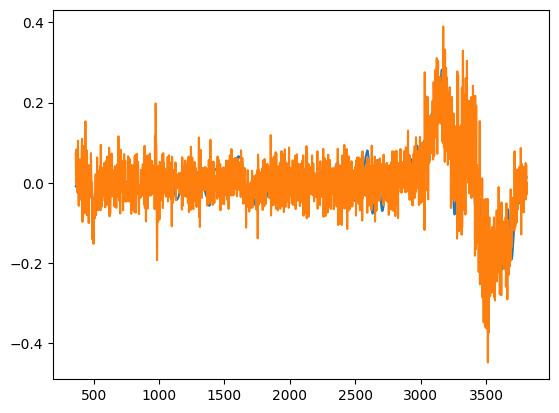

In [10]:
# Visualize spectra
plt.plot(x_axis, data[0])
plt.plot(x_axis, aligned_values_water)
plt.show()

# Visualize diferenced spectra
plt.plot(x_axis[:-1], differences_spectra[0])
plt.plot(x_axis[:-1], differences_water[0])
plt.show()

In [11]:
from numpy import dot
from numpy.linalg import norm
from scipy import spatial

def cosine_similarity(a, b):
    if a.shape != b.shape:
        raise ValueError("The shapes of both arrays must be the same")

    # Compute the norms of each row
    norms_a = norm(a, axis=1)
    norms_b = norm(b, axis=1)

    # Compute the dot product of corresponding rows
    dot_product = np.sum(a * b, axis=1)

    # Calculate cosine similarity
    similarities = dot_product / (norms_a * norms_b)

    return similarities

#distances = np.zeros_like(differences_spectra)

#for spectrum in differences_spectra:
print(data.shape)
print(differences_water.shape)
print(np.tile(differences_water[0], [differences_spectra.shape[0], 1]).shape)
distances = 1 - cosine_similarity(np.tile(differences_water[0], [differences_spectra.shape[0], 1]), differences_spectra) # 1 - to get a distance
# distances = np.array([spatial.distance.cosine(differences_water[0], spectrum) for spectrum in differences_spectra])
print(distances.shape)
print(distances)

(1200, 1528)
(1, 1527)
(1200, 1527)
(1200,)
[0.29645202 0.28329467 0.32119703 ... 0.30066749 0.29567098 0.32293804]


520: 0.26849127839902753


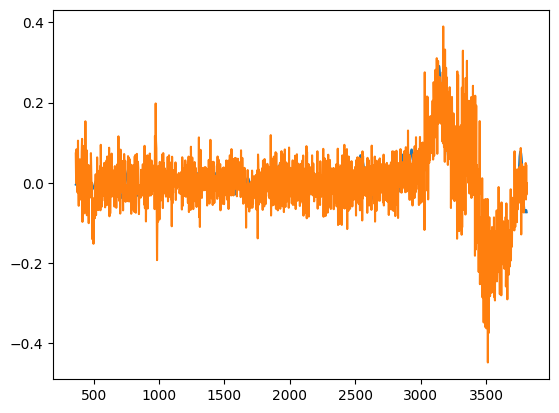

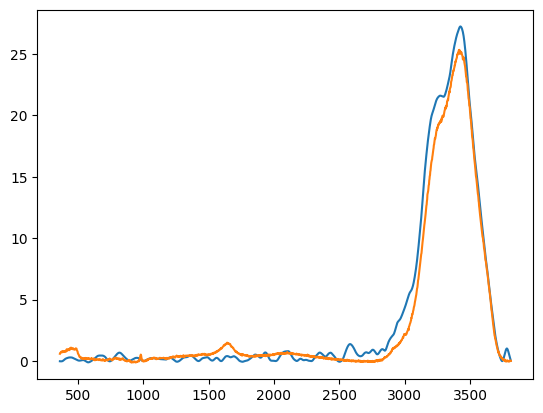

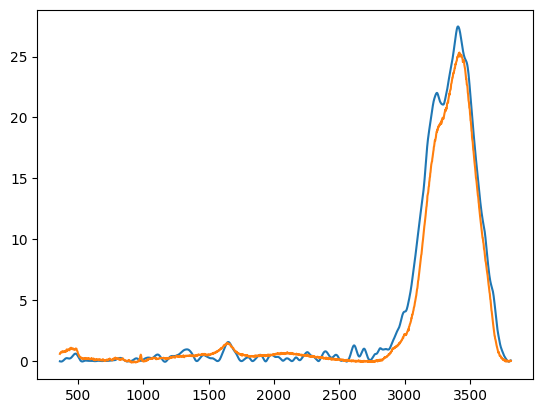

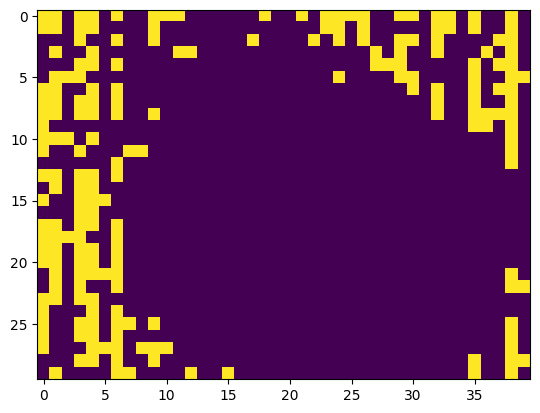

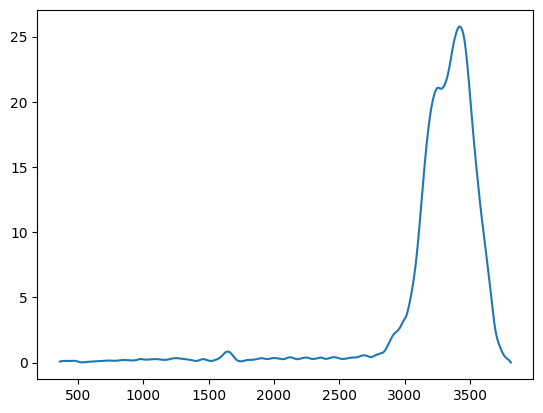

In [23]:
# get closest spectrum to water from orig. data

best_similarity = np.argmin(np.abs(distances)) # abs just to be sure
print(f"{best_similarity}: {distances[best_similarity]}")

plt.plot(x_axis[:-1], differences_spectra[best_similarity])
plt.plot(x_axis[:-1], differences_water[0])
plt.show()

plt.plot(x_axis, data[best_similarity])
plt.plot(x_axis, aligned_values_water)
plt.show()

plt.plot(x_axis, data[0])
plt.plot(x_axis, aligned_values_water)
plt.show()

map = np.reshape(np.where(np.abs(distances) < 0.3, 1, 0), (map_shape[1], map_shape[0], -1))
plt.imshow(map)
plt.show()

average_water = np.mean(data[np.abs(distances) < 0.3], axis=0)
plt.plot(x_axis, average_water)
plt.show()


# ALGO

# On preprocessed data - that means cropped, CR removed, BG removed, smoothed (if not, we smooth it here to find the best water, TODO: try)
# 1. Preprocess pure water spectrum - interpolate it to the same x axis as the data (align the x axes)
# 2. Calculate differences between the spectra to get rid of the different heights
# 3. Calculate cosine similarity between the water and the data
# 4. Find the best matches based on the threshold
# 5. Average the best matches to get the average water spectrum from our data
# 6. Use this average water spectrum for normalization of the data
#
# Things to think about:
# - What is the best threshold for the cosine similarity?
# - What is the best way to average the best matches? Do we do some weighting based on the similarity?
# - What to do if we do not find any good matches?


11386.673753457075
8.78219593932243


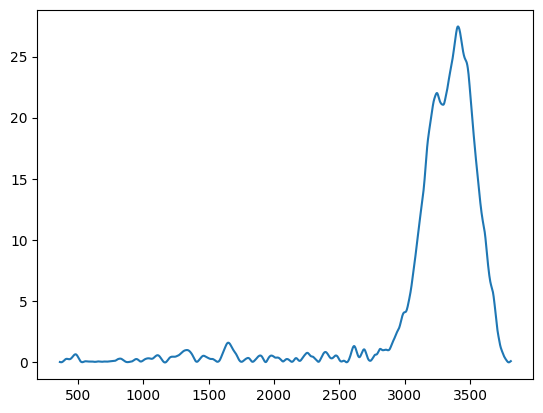

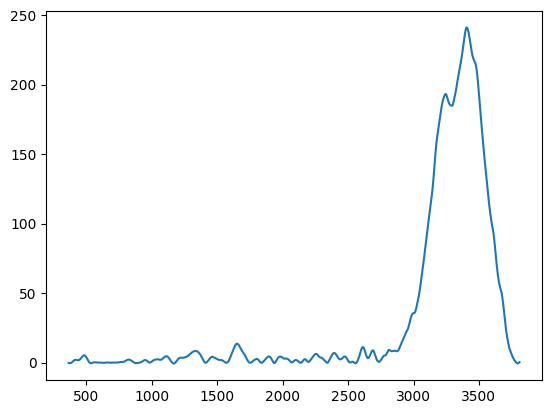

In [27]:
# do the actual normalization

# Jana P. (21.2.2022, 22:41): integrate signal between 2800 and 3800 cm-1
# Sarka (pdf manual sent by Peter 23. 2. 2022, 14:51): integrate the area of valence vibrations of water  and find normalization factor so that this integral is equal 100000. Multiply the spectral map by this normalization factor.
# TODO: check with Peter

# find the indexes of the x axis where the values are between 2800 and 3800
start_index = np.where(x_axis >= 2800)[0][0]
end_index = np.where(x_axis <= 3800)[0][-1]
water_band = average_water[start_index:end_index]
water_band_integral = np.trapz(water_band, x_axis[start_index:end_index])

normalization_factor = 100000 / water_band_integral
print(water_band_integral)
print(normalization_factor)


normalized_data = data * normalization_factor
plt.plot(x_axis, data[0])
plt.show()

plt.plot(x_axis, normalized_data[0])
plt.show()
